# Imports

In [2]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from pylab import rcParams
import seaborn as sns
from array import array
import math
import numpy as np
from scipy.stats import ttest_ind
from scipy.stats import linregress
from scipy.stats import mannwhitneyu
import statistics
%matplotlib inline


# Useful functions

In [3]:
begins=[]
ends=[]
names =[]
with open ("CommonData/sequence.gb") as f:
    in_pep = False
    for l in f:
        if "mat_peptide" in l:
            begins.append(int(l.split()[1].split("..")[0]))
            ends.append(int(l.split()[1].split("..")[1]))
            in_pep = True
        elif in_pep :
            names.append(l.split("=")[1])
            in_pep = False
            
print(begins)
print(ends)
print(names)

[108, 474, 753, 978, 2490, 3546, 4224, 4614, 6465, 6846, 6915, 7668]
[473, 752, 977, 2489, 3545, 4223, 4613, 6464, 6845, 6914, 7667, 10376]
['"capsid"\n', '"propeptide"\n', '"membrane"\n', '"envelope"\n', '"NS1"\n', '"NS2A"\n', '"NS2B"\n', '"NS3"\n', '"NS4A"\n', '"2K"\n', '"NS4B"\n', '"NS5"\n']


In [4]:
# Interesting positions
positions=[316,1670,1785,2340,5935,7172,8449,9165]
def plot_positions():
    for x in positions:
        plt.axvline(x=x, linewidth=1, linestyle=':')
        
def plot_genes():
    for i in range(len(begins)):
        plt.plot([begins[i], begins[i]], [0.99,1.0], linewidth=2, linestyle='-', color="black")
        if i%2==0:
            plt.text (begins[i] + ((ends[i] - begins[i])/10), 1.005, (names[i].replace('"', ''))[0:3], size='xx-small')
        else:
            plt.text (begins[i] + ((ends[i] - begins[i])/10), 1.015, (names[i].replace('"', ''))[0:3], size='xx-small')
    plt.plot([ends[-1], ends[-1]], [0.99,1.0], linewidth=2, linestyle='-', color="black")



In [5]:
def synonymous (row):
    if row['null'] or (row['Consensus_aa']==row['Secondbase_aa'] ):
        return "synonymous" 
    else:
        return "non-synonymous"

def add_columns(table):
    table['null'] = (table['Secondbase_aa']).isnull()
    table['is_synonymous'] = table.apply (lambda row: synonymous (row),axis=1)
    table['1_major_variant_frequency'] = 1.0 - table['Major_variant_frequency_quality_corrected']

In [6]:
def is_increasing(minor_frequencies):
    #print(minor_frequencies)
    tolerance = 0.01
    minimum_increase = 0.1
    previous = minor_frequencies[0]
    if minor_frequencies[-1] - minor_frequencies[0] < minimum_increase:
        return False
    for m in range(1,len(minor_frequencies)):
        if previous < minor_frequencies[m] or previous < minor_frequencies[m] + tolerance:
            #print(str(previous) + " < " + str(minor_frequencies[m]))
            previous = minor_frequencies[m]
        else:
            return False
    return True


# Strict definition of an increasing position
def is_strictly_increasing(minor_frequencies):
    #print(minor_frequencies)
    previous = minor_frequencies[0]
    for m in range(1,len(minor_frequencies)):
        if previous < minor_frequencies[m]:
            #print(str(previous) + " < " + str(minor_frequencies[m]))
            previous = minor_frequencies[m]
        else:
            return False
    return True


def get_variant_frequency(variant, table, i):
    sum_of_bases = table['As_quality_corrected'][i]+table['Cs_quality_corrected'][i]+table['Gs_quality_corrected'][i]+table['Ts_quality_corrected'][i]+table['Ns_quality_corrected'][i]
    if variant == "A":
        return table["As_quality_corrected"][i] / sum_of_bases
    elif variant == "C":
        return table["Cs_quality_corrected"][i] / sum_of_bases
    elif variant == "G":
        return table["Gs_quality_corrected"][i] / sum_of_bases
    elif variant == "T":
        return table["Ts_quality_corrected"][i] / sum_of_bases
    else:
        return np.nan
        

def get_increasing_variants(tables):
    num_tables = len(tables)
    first = tables[0]
    last = tables[num_tables-1]
    major = ""
    minor = ""
    major_frequencies = array('d',[0.0]*num_tables)
    minor_frequencies = array('d',[0.0]*num_tables)
    increasingVariants = dict()
    for i in first["Position"]:
        major = first["Major_variant"][i]
        #print(last['Major_variant_frequency_quality_corrected'][i])
        major_frequencies[0] = first['Major_variant_frequency_quality_corrected'][i]
        if major == last["Major_variant"][i]:
            minor = last["Second_variant"][i]
        else:
            minor = last["Major_variant"][i]
        minor_frequencies[0] = get_variant_frequency(minor, first, i)
        for table_id in range(1, num_tables):
            major_frequencies[table_id] = get_variant_frequency(major, tables[table_id], i)
            minor_frequencies[table_id] = get_variant_frequency(minor, tables[table_id], i)
        if is_increasing(minor_frequencies):
            increasingVariants[i] = [major_frequencies.tolist(), minor_frequencies.tolist()]
    return increasingVariants


def printMajorFrequencyThroughSamples(tables, numPos):
    major = tables[0]['Major_variant'][numPos]
    last_major = tables[0]['Major_variant'][numPos]
    print("Position "+ str(numPos) +", Major variant in first sample: " + major)
    print("Position "+ str(numPos) +", Frequencies of "+major+" through the samples: ")
    for i in range(len(tables)):
        print("\t"+str(get_variant_frequency(major, tables[i], numPos)))
    print("Position "+ str(numPos) +", Major variant in last sample: " + tables[-1]['Major_variant'][numPos])

    
def printMajorFrequencyThroughSamples_2340_7172(tables):
    printMajorFrequencyThroughSamples(tables, 2340)
    printMajorFrequencyThroughSamples(tables, 7172)

In [7]:
# Functions to think in terms of standard deviation of the frequency per site
def get_varying_variants(tables):
    sd_threshold = 0.1
    num_tables = len(tables)
    first = tables[0]
    last = tables[num_tables-1]
    major = ""
    minor = ""
    major_frequencies = array('d',[0.0]*num_tables)
    minor_frequencies = array('d',[0.0]*num_tables)
    varyingVariants = dict()
    for i in first["Position"]:
        major = first["Major_variant"][i]
        #print(last['Major_variant_frequency_quality_corrected'][i])
        major_frequencies[0] = first['Major_variant_frequency_quality_corrected'][i]
        for table_id in range(1, num_tables):
            major_frequencies[table_id] = get_variant_frequency(major, tables[table_id], i)
        sd_value = statistics.pstdev(major_frequencies)
        if sd_value > sd_threshold:
            varyingVariants[i] = sd_value
    print("There are "+str(len(varyingVariants))+" positions whose major variant varies a lot in frequency.")
    print("Those are:")
    print(varyingVariants.keys())
    return varyingVariants


# Reading the data

In [8]:
# Control runs, replicate A
DD3_A = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD3A_1_sequence.txt.assembled.fastq_mapped_AA.csv", na_values=" -nan")
add_columns(DD3_A)
DD6_A = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD6A_1_sequence.txt.assembled.fastq_mapped_AA.csv", na_values=" -nan")
add_columns(DD6_A)
DD9_A = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD9A_1_sequence.txt.assembled.fastq_mapped_AA.csv", na_values=" -nan")
add_columns(DD9_A)
DD12_A = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD12A_1_sequence.txt.assembled.fastq_mapped_AA.csv", na_values=" -nan")
add_columns(DD12_A)
DD18_A = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1DD18A_1_sequence.txt.assembled.fastq_mapped_AA.csv", na_values=" -nan")
add_columns(DD18_A)
DD24_A = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD24A_1_sequence.txt.assembled.fastq_mapped_AA.csv", na_values=" -nan")
add_columns(DD24_A)
DD51_A = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD51A_1_sequence.txt.assembled.fastq_mapped_AA.csv", na_values=" -nan")
add_columns(DD51_A)
DD51_A_no_reamp = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD51Anoreamplification_1_sequence.txt.assembled.fastq_mapped_AA.csv", na_values=" -nan")
add_columns(DD51_A_no_reamp)

tables_A = [DD3_A, DD6_A, DD9_A, DD12_A, DD18_A, DD24_A, DD51_A]


In [9]:
# Control runs, replicate D
DD3_D = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD3D_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(DD3_D)
DD6_D = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD6D_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(DD6_D)
DD9_D = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD9D_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(DD9_D)
DD12_D = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD12D_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(DD12_D)
DD18_D = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1DD18D_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(DD18_D)
DD24_D = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD24D_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(DD24_D)

tables_D = [DD3_D, DD6_D, DD9_D, DD12_D, DD18_D, DD24_D]


In [10]:
# Control runs, replicate E
DD3_E = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1DD3E_1_sequence.txt.assembled.fastq_mapped_AA.csv")
DD6_E = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD6E_1_sequence.txt.assembled.fastq_mapped_AA.csv")
DD9_E = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD9E_1_sequence.txt.assembled.fastq_mapped_AA.csv")
DD12_E = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1DD12E_1_sequence.txt.assembled.fastq_mapped_AA.csv")
DD18_E = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1DD18E_1_sequence.txt.assembled.fastq_mapped_AA.csv")
DD24_E = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1DD24E_1_sequence.txt.assembled.fastq_mapped_AA.csv")
DD24crude_E = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1DD24Ecrude_1_sequence.txt.assembled.fastq_mapped_AA.csv")

add_columns(DD3_E)
add_columns(DD6_E)
add_columns(DD9_E)
add_columns(DD12_E)
add_columns(DD18_E)
add_columns(DD24_E)
add_columns(DD24crude_E)

tables_E = [DD3_E, DD6_E, DD9_E, DD12_E, DD18_E, DD24_E]

In [11]:
# TLR3 activation runs, replicate A
TD9_A = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1TD9A_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(TD9_A)
TD12_A = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1TD12A_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(TD12_A)
TD18_A = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1TD18A_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(TD18_A)
TD24_A = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1TD24A_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(TD24_A)
TD51_A = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1TD51A_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(TD51_A)

tables_TA = [TD9_A, TD12_A, TD18_A, TD24_A, TD51_A]

In [12]:
# TLR3 activation runs, replicate D
TD9_D = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1TD9D_1_sequence.txt.assembled.fastq_mapped_AA.csv")
TD12_D = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1TD12D_1_sequence.txt.assembled.fastq_mapped_AA.csv")
TD18_D = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1TD18D_1_sequence.txt.assembled.fastq_mapped_AA.csv")
TD24_D = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1TD24D_1_sequence.txt.assembled.fastq_mapped_AA.csv")

add_columns(TD9_D)
add_columns(TD12_D)
add_columns(TD18_D)
add_columns(TD24_D)

tables_TD = [TD9_D, TD12_D, TD18_D, TD24_D]

In [13]:
# TLR3 activation runs, replicate E
TD9_E = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1TD9E_1_sequence.txt.assembled.fastq_mapped_AA.csv")
TD12_E = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1TD12E_1_sequence.txt.assembled.fastq_mapped_AA.csv")
TD18_E = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1TD18E_1_sequence.txt.assembled.fastq_mapped_AA.csv")
TD24_E = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1TD24E_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(TD9_E)
add_columns(TD12_E)
add_columns(TD18_E)
add_columns(TD24_E)

tables_TE = [TD9_E, TD12_E, TD18_E, TD24_E]

In [14]:
# All tables
all_tables = tables_A+tables_D+tables_E+tables_TA+tables_TD+tables_TE
all_table_names = ["DD3_A", "DD6_A", "DD9_A", "DD12_A", "DD18_A", "DD24_A", "DD51_A", "DD3_D", "DD6_D", "DD9_D", "DD12_D", "DD18_D", "DD24_D", "DD3_E", "DD6_E", "DD9_E", "DD12_E", "DD18_E", "DD24_E", "TD9_A", "TD12_A", "TD18_A", "TD24_A", "TD51_A", "TD9_D", "TD12_D", "TD18_D", "TD24_D", "TD9_E", "TD12_E", "TD18_E", "TD24_E"]

# Positions that increase in frequency in the different replicates and conditions

In [15]:
increasing_A = get_increasing_variants(tables_A)
print("There are "+str(len(increasing_A))+" positions that rise in frequency.")
print("Those are:")
print(increasing_A.keys())

There are 9 positions that rise in frequency.
Those are:
dict_keys([276, 316, 1670, 1785, 2340, 5935, 7172, 8449, 9165])


/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars


## Plotting only positions that consistently rise in frequency, control, replicate A

In [16]:
def plot_increasing_positions(increasing_pos, last_time_point) :
    sns.set_palette("hls")
    sns.set_context("poster")
    increasing_pos_keys = increasing_pos.keys()
    Is_increasing = []
    for i in last_time_point['Position']:
        if i in increasing_pos_keys:
            Is_increasing.append("Increasing")
        else:
            Is_increasing.append("Not increasing")
        
    to_plot = pd.DataFrame ({'Position':last_time_point['Position'], 'Major_variant_frequency_quality_corrected':last_time_point ['Major_variant_frequency_quality_corrected'],'Is_increasing':Is_increasing, 'is_synonymous':last_time_point ['is_synonymous']}) 
    ax=sns.lmplot( x="Position", y="Major_variant_frequency_quality_corrected", data=to_plot, fit_reg=False, hue='Is_increasing', row='is_synonymous', legend=False, size=7, aspect=2)
    ax.set(xlabel='Position along the genome', ylabel='Major variant frequency, last time point')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plot_positions()


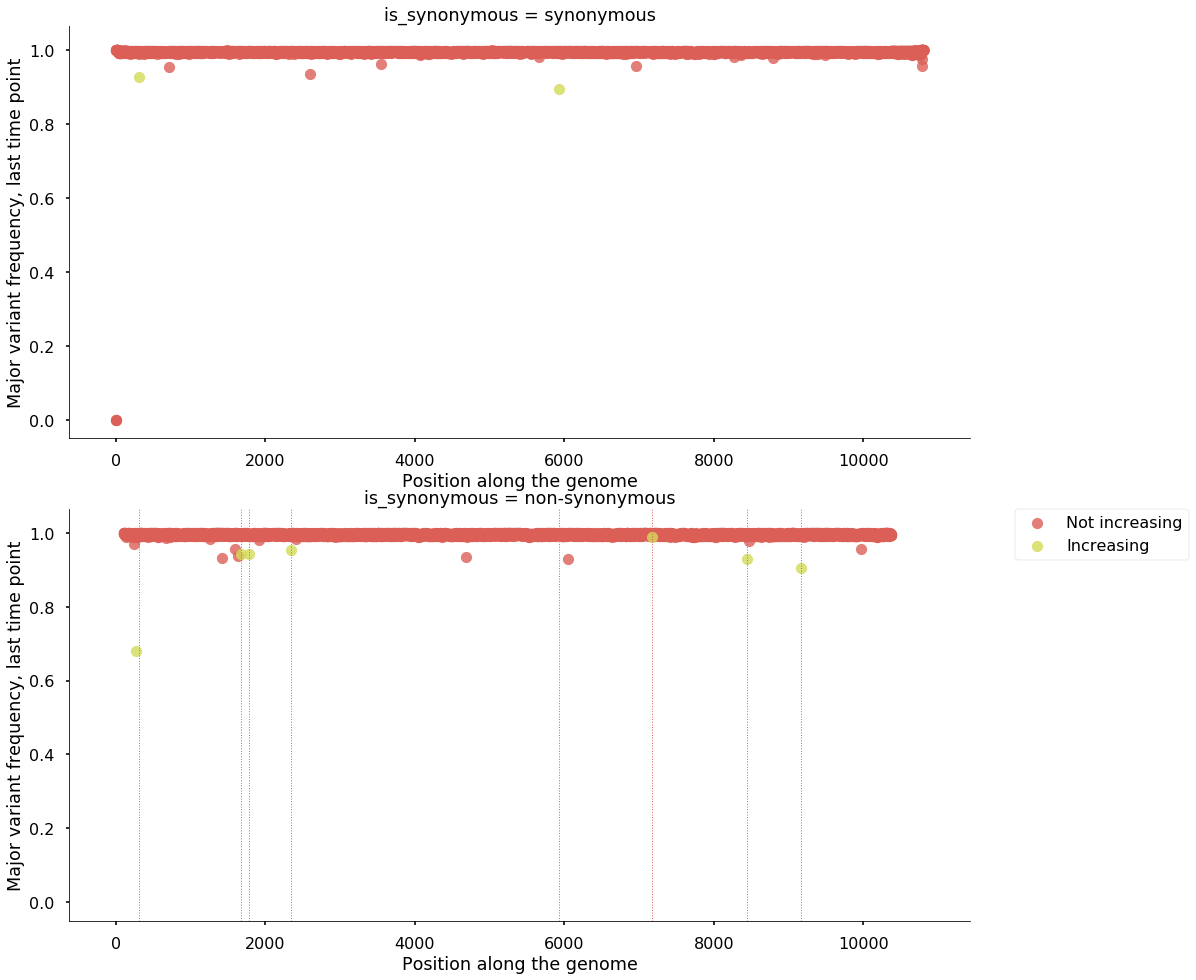

In [17]:
plot_increasing_positions(increasing_A, DD51_A)

## Write out the table

In [18]:
def write_increasing_positions(increasing_pos, tables, exp_names, filename) :
    increasing_pos_table = pd.DataFrame()

    for d in tables:
        increasing_pos_table = pd.concat([increasing_pos_table,d[d['Position'].isin(increasing_pos)]])

    num = len(increasing_pos)

    expnames_iterated = []
    for i in exp_names : 
        expnames_iterated.append([i]*num)

    expnames = [item for sublist in expnames_iterated for item in sublist]
    print(len(expnames))
    increasing_pos_table['expName']=expnames
    increasing_pos_table.to_csv( filename )


In [19]:
write_increasing_positions(increasing_A, tables_A, ["DD3_A", "DD6_A", "DD9_A", "DD12_A", "DD18_A", "DD24_A", "DD51_A"], "increasing_A.csv")



63


In [20]:
printMajorFrequencyThroughSamples_2340_7172(tables_A)

Position 2340, Major variant in first sample: C
Position 2340, Frequencies of C through the samples: 
	0.954084792406
	0.770773463935
	0.323386292861
	0.189711679857
	0.0510550755649
	0.0510580861686
	0.0462377146563
Position 2340, Major variant in last sample: T
Position 7172, Major variant in first sample: T
Position 7172, Frequencies of T through the samples: 
	0.991364022092
	0.949874400255
	0.61312382108
	0.305338310592
	0.0489461569329
	0.00757326109818
	0.00830987093771
Position 7172, Major variant in last sample: C


## Plotting only positions that consistently rise in frequency, control, replicate D

In [21]:
increasing_D = get_increasing_variants(tables_D)
print("There are "+str(len(increasing_D))+" positions that rise in frequency.")
print("Those are:")
print(increasing_D.keys())

/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars


There are 5 positions that rise in frequency.
Those are:
dict_keys([1916, 2069, 2193, 6558, 7172])


/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars


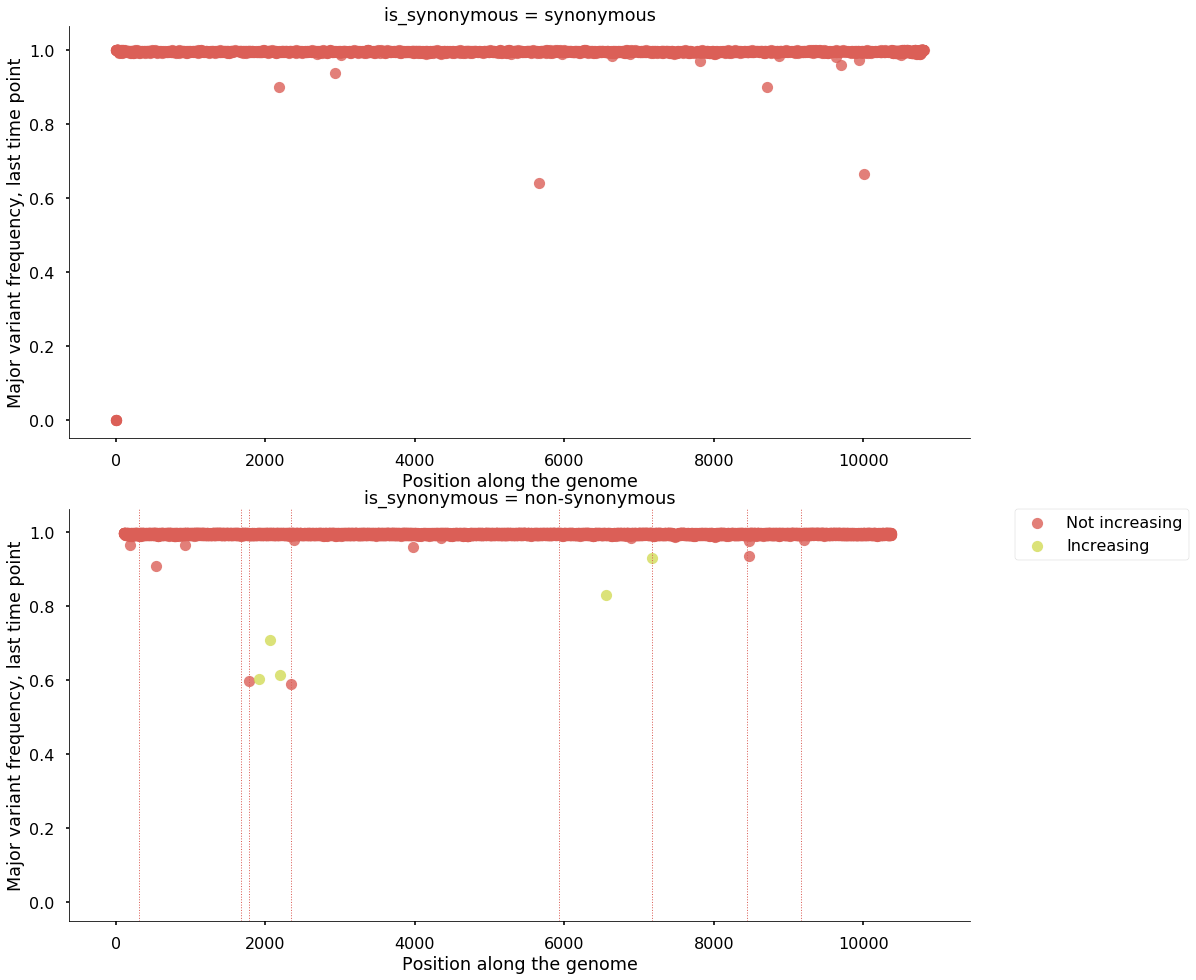

In [22]:
plot_increasing_positions(increasing_D, DD24_D)


In [23]:
write_increasing_positions(increasing_D, tables_D, ["DD3_D", "DD6_D", "DD9_D", "DD12_D", "DD18_D", "DD24_D"], "increasing_D.csv")


30


In [24]:
printMajorFrequencyThroughSamples_2340_7172(tables_D)

Position 2340, Major variant in first sample: C
Position 2340, Frequencies of C through the samples: 
	0.92085831926
	0.603016491554
	0.363261243759
	0.509316467364
	0.499439930152
	0.589577729383
Position 2340, Major variant in last sample: C
Position 7172, Major variant in first sample: T
Position 7172, Frequencies of T through the samples: 
	0.983698285449
	0.975063214298
	0.970285675145
	0.917198477238
	0.423190267905
	0.0659561340323
Position 7172, Major variant in last sample: C


## Plotting only positions that consistently rise in frequency, control, replicate E

In [25]:
increasing_E = get_increasing_variants(tables_E)
print("There are "+str(len(increasing_E))+" positions that rise in frequency.")
print("Those are:")
print(increasing_E.keys())

There are 5 positions that rise in frequency.
Those are:
dict_keys([346, 533, 2193, 3566, 7172])


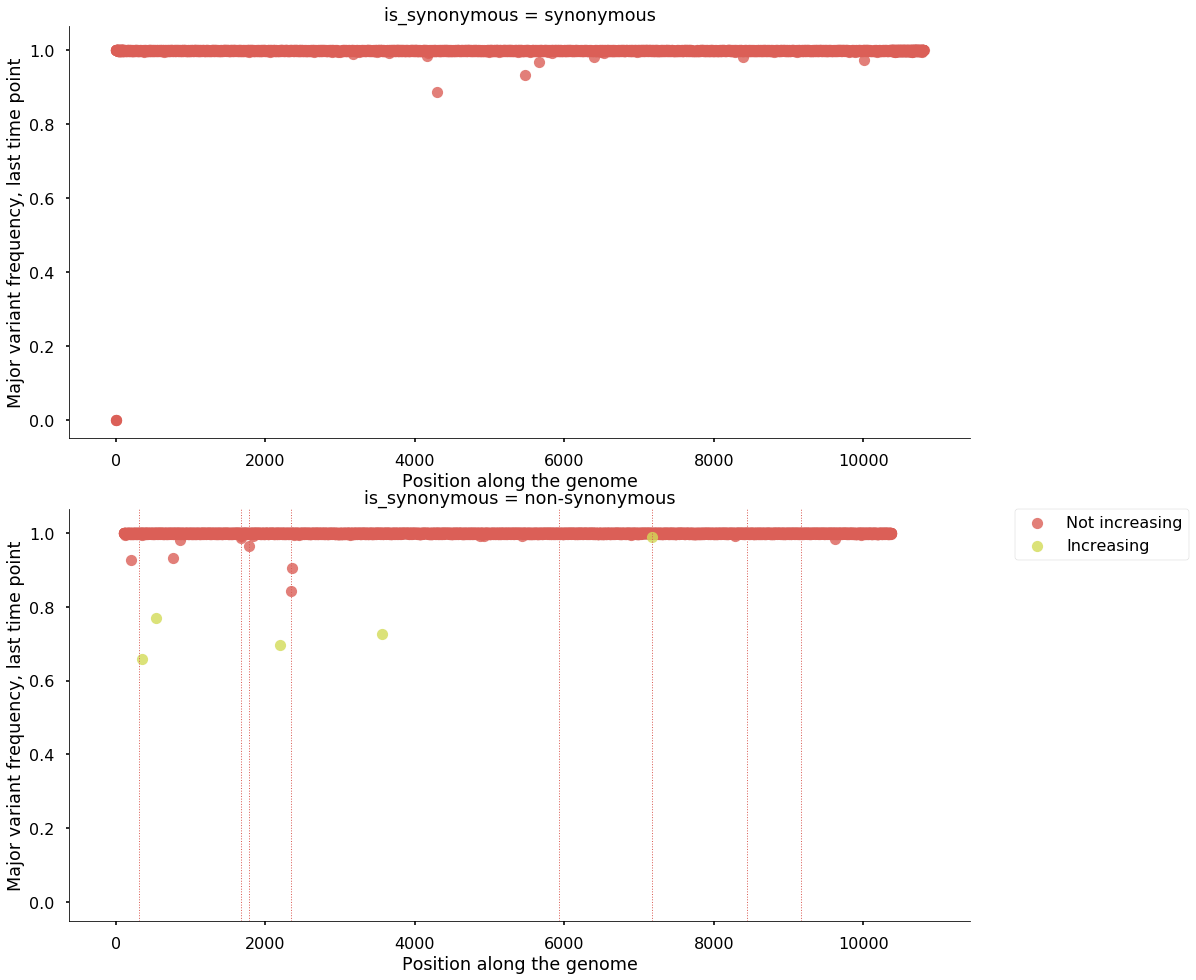

In [26]:
plot_increasing_positions(increasing_E, DD24_E)

In [27]:

write_increasing_positions(increasing_E, tables_E, ["DD3_E", "DD6_E", "DD9_E", "DD12_E", "DD18_E", "DD24_E"], "increasing_E.csv")


30


In [28]:
printMajorFrequencyThroughSamples_2340_7172(tables_E)

Position 2340, Major variant in first sample: C
Position 2340, Frequencies of C through the samples: 
	0.916253884864
	0.360765542572
	0.260066131256
	0.233711917547
	0.30174975959
	0.84237382973
Position 2340, Major variant in last sample: C
Position 7172, Major variant in first sample: T
Position 7172, Frequencies of T through the samples: 
	0.984934499625
	0.969611081946
	0.93240865708
	0.831498578294
	0.249904250813
	0.0107104657983
Position 7172, Major variant in last sample: C


## Plotting only positions that consistently rise in frequency, treatment, replicate A

In [29]:
increasing_TA = get_increasing_variants(tables_TA)
print("There are "+str(len(increasing_TA))+" positions that rise in frequency.")
print("Those are:")
print(increasing_TA.keys())

/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars


There are 14 positions that rise in frequency.
Those are:
dict_keys([284, 1419, 1670, 1785, 1874, 2340, 3709, 4606, 5662, 5934, 7172, 8519, 9526, 10006])


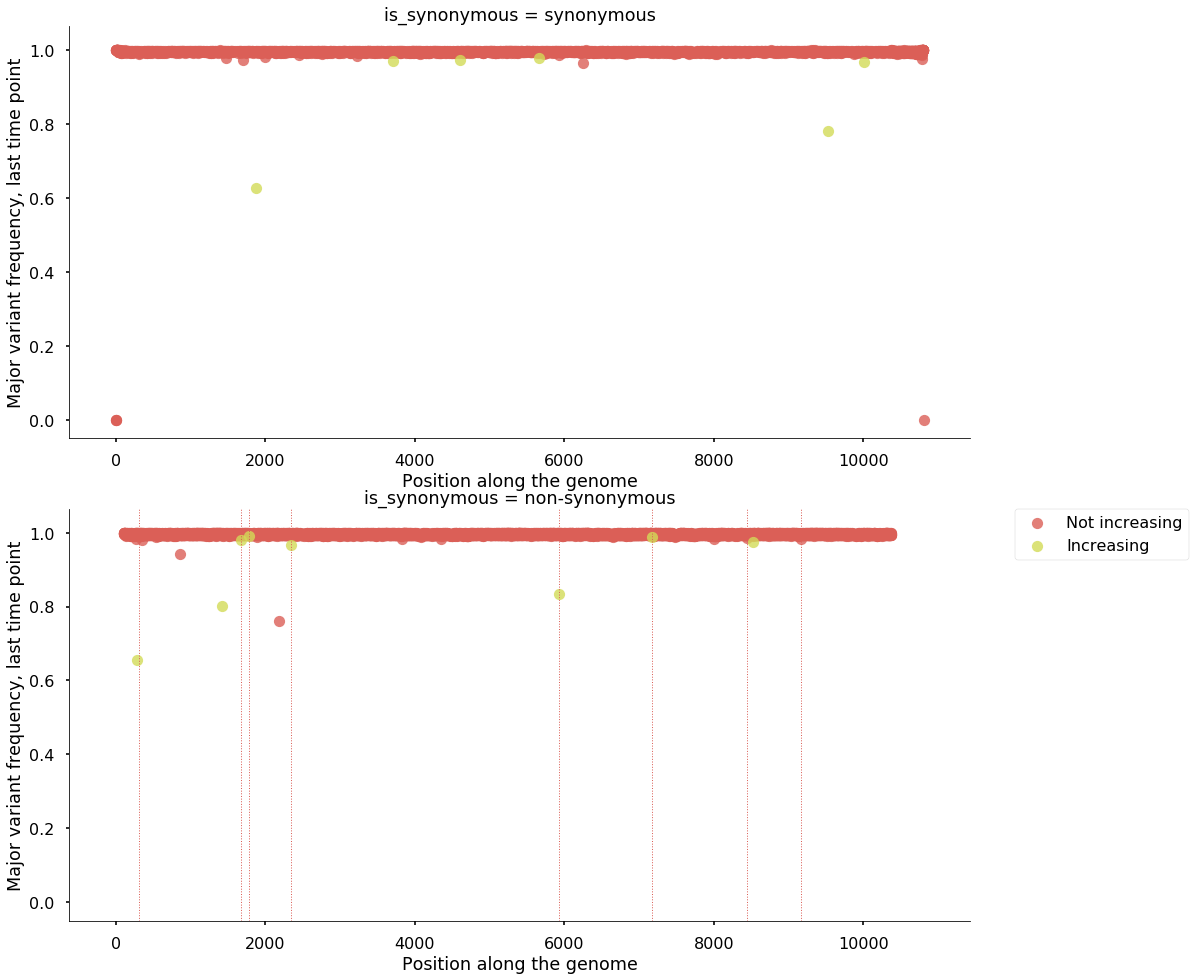

In [30]:
plot_increasing_positions(increasing_TA, TD51_A)

In [31]:
write_increasing_positions(increasing_TA, tables_TA, [ "TD9_A", "TD12_A", "TD18_A", "TD24_A", "TD51_A"], "increasing_TA.csv")


70


### Analysis of positions 2340 and 7172

In [32]:
printMajorFrequencyThroughSamples_2340_7172(tables_TA)

Position 2340, Major variant in first sample: C
Position 2340, Frequencies of C through the samples: 
	0.757187314912
	0.0612236489297
	0.0547018462891
	0.0273568229937
	0.0311277307958
Position 2340, Major variant in last sample: T
Position 7172, Major variant in first sample: T
Position 7172, Frequencies of T through the samples: 
	0.950172926618
	0.59322093797
	0.0256248255212
	0.00565504637167
	0.00545720661318
Position 7172, Major variant in last sample: C


## Plotting only positions that consistently rise in frequency, treatment, replicate D

In [33]:
increasing_TD = get_increasing_variants(tables_TD)
print("There are "+str(len(increasing_TD))+" positions that rise in frequency.")
print("Those are:")
print(increasing_TD.keys())

/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars


There are 7 positions that rise in frequency.
Those are:
dict_keys([860, 943, 1670, 1883, 2078, 3558, 4691])


/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars


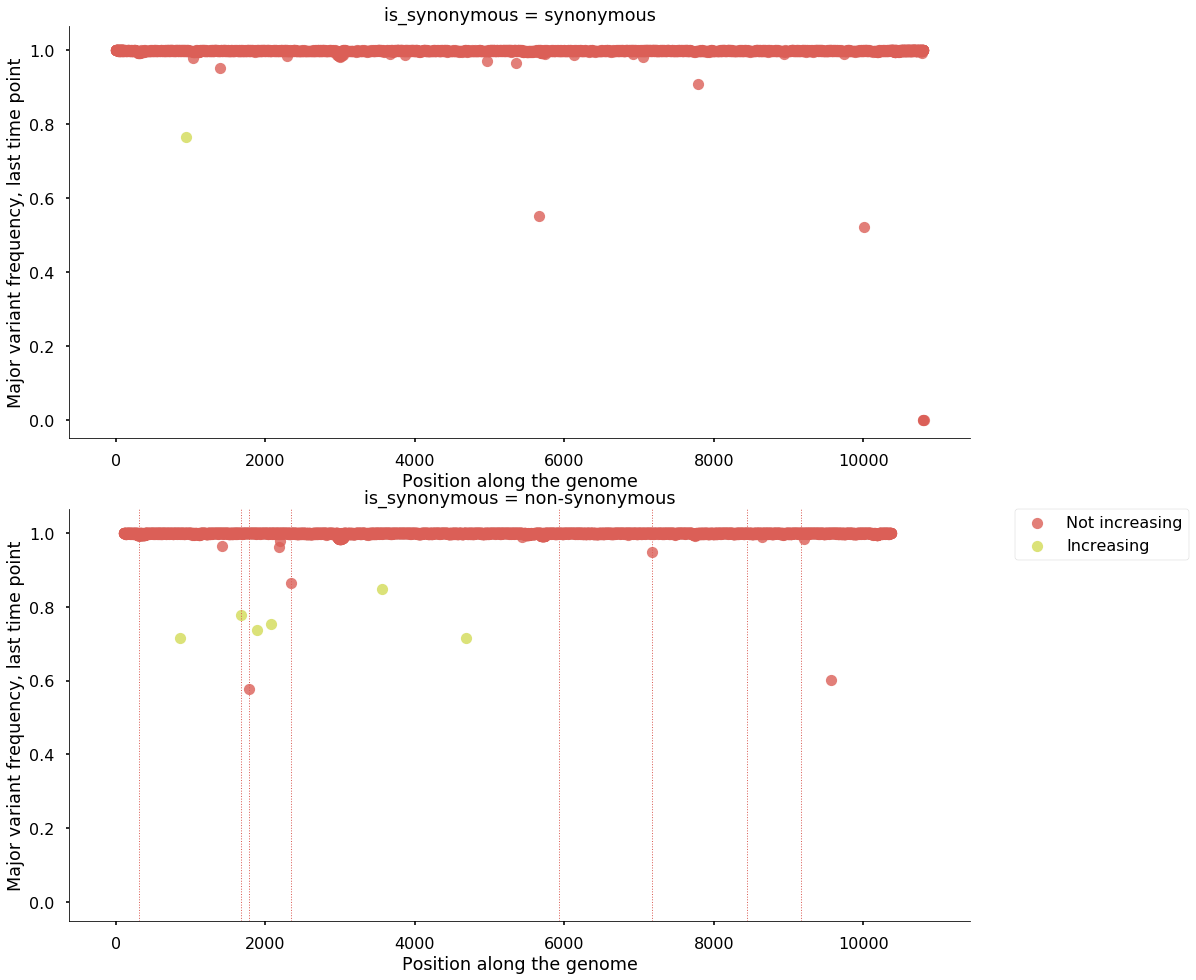

In [34]:
plot_increasing_positions(increasing_TD, TD24_D)

### Analysis of positions 2340 and 7172

In [35]:
printMajorFrequencyThroughSamples_2340_7172(tables_TD)


Position 2340, Major variant in first sample: T
Position 2340, Frequencies of T through the samples: 
	0.936179369195
	0.968023532791
	0.965847794947
	0.862914095139
Position 2340, Major variant in last sample: T
Position 7172, Major variant in first sample: T
Position 7172, Frequencies of T through the samples: 
	0.993431566474
	0.98365650347
	0.915636145492
	0.948446285978
Position 7172, Major variant in last sample: T


In [36]:
write_increasing_positions(increasing_TD, tables_TD, [ "TD9_D", "TD12_D", "TD18_D", "TD24_D"], "increasing_TD.csv")


28


## Plotting only positions that consistently rise in frequency, treatment, replicate E

In [37]:
increasing_TE = get_increasing_variants(tables_TE)
print("There are "+str(len(increasing_TE))+" positions that rise in frequency.")
print("Those are:")
print(increasing_TE.keys())

/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars


There are 6 positions that rise in frequency.
Those are:
dict_keys([1785, 2287, 2340, 5662, 7172, 10006])


/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars


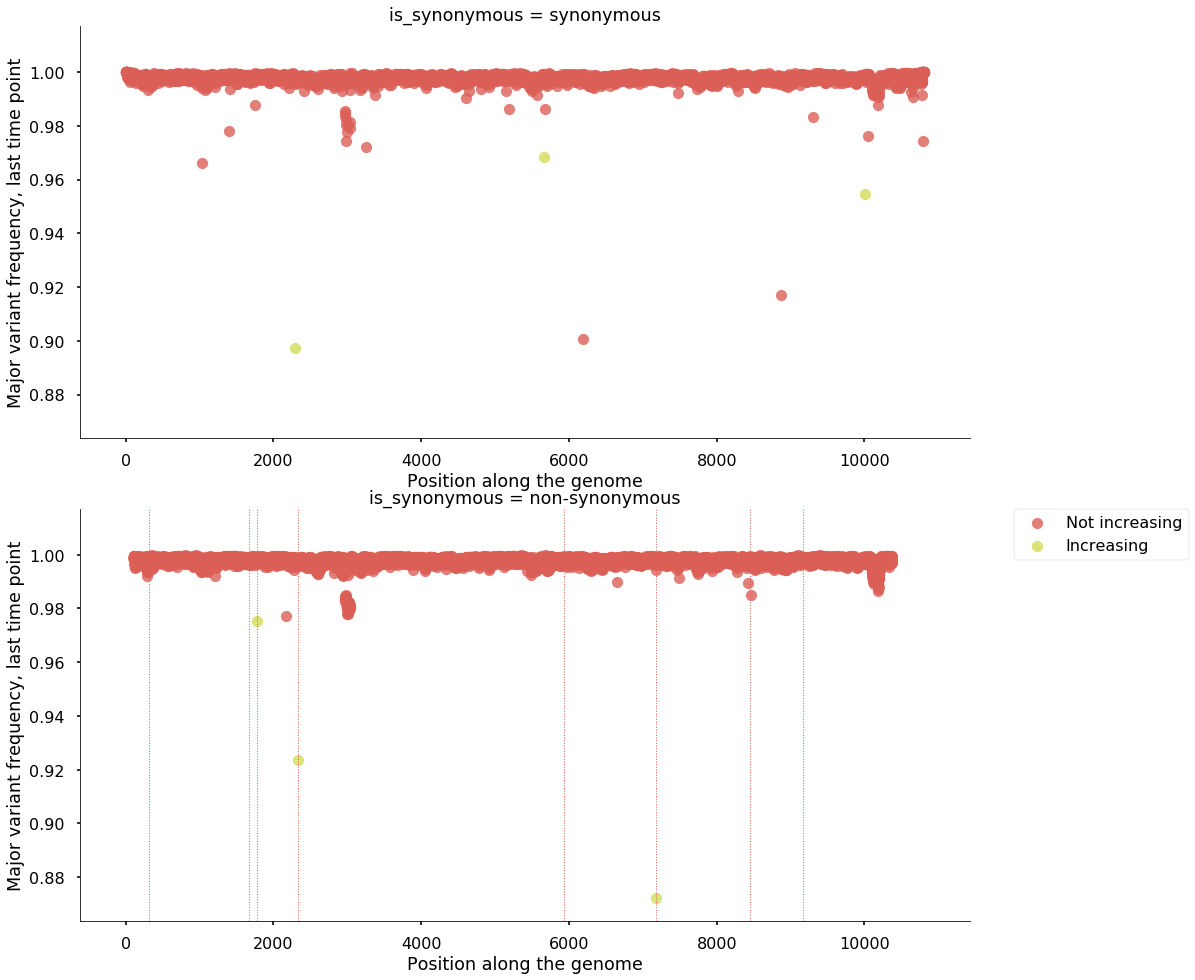

In [38]:
plot_increasing_positions(increasing_TE, TD24_E)

In [39]:

write_increasing_positions(increasing_TE, tables_TE, [ "TD9_E", "TD12_E", "TD18_E", "TD24_E"], "increasing_TE.csv")


24


### Analysis of positions 2340 and 7172


In [40]:
printMajorFrequencyThroughSamples_2340_7172(tables_TE)

Position 2340, Major variant in first sample: C
Position 2340, Frequencies of C through the samples: 
	0.564407358141
	0.407228847204
	0.230194263227
	0.0742056231659
Position 2340, Major variant in last sample: T
Position 7172, Major variant in first sample: T
Position 7172, Frequencies of T through the samples: 
	0.994199378002
	0.983771405976
	0.854892054765
	0.127092217113
Position 7172, Major variant in last sample: C


# Analysis of positions whose frequency varies a lot

In [41]:
varying_A = get_varying_variants(tables_A)

There are 9 positions whose major variant varies a lot in frequency.
Those are:
dict_keys([276, 316, 1670, 1785, 2340, 5935, 7172, 8449, 9165])


/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars


In [42]:
varying_D = get_varying_variants(tables_D)

/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars


There are 6 positions whose major variant varies a lot in frequency.
Those are:
dict_keys([1785, 1916, 2069, 2193, 2340, 7172])


/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars


In [43]:
varying_E = get_varying_variants(tables_E)

There are 11 positions whose major variant varies a lot in frequency.
Those are:
dict_keys([346, 533, 1785, 2193, 2340, 2359, 3566, 4297, 5662, 7172, 10006])


In [44]:
varying_TA = get_varying_variants(tables_TA)

/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars


There are 11 positions whose major variant varies a lot in frequency.
Those are:
dict_keys([284, 1670, 1785, 1874, 2340, 3709, 4606, 5662, 7172, 8519, 10006])


In [45]:
varying_TD = get_varying_variants(tables_TD)

There are 9 positions whose major variant varies a lot in frequency.
Those are:
dict_keys([860, 943, 1785, 1883, 2078, 4691, 5662, 9564, 10006])


/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars


In [46]:
varying_TE = get_varying_variants(tables_TE)

There are 8 positions whose major variant varies a lot in frequency.
Those are:
dict_keys([1397, 1785, 2177, 2287, 2340, 5662, 7172, 10006])


In [47]:
all_varying = [varying_A,varying_D,varying_E,varying_TA,varying_TD,varying_TE]
def build_table_for_plotting_varying_pos (all_varying):
    all_keys = list()
    for di in all_varying:
        all_keys = all_keys + list(di.keys())
    return(Counter(all_keys))
counts = build_table_for_plotting_varying_pos(all_varying)
print (counts)

Counter({1785: 6, 2340: 5, 7172: 5, 5662: 4, 10006: 4, 1670: 2, 2193: 2, 276: 1, 316: 1, 5935: 1, 8449: 1, 9165: 1, 1916: 1, 2069: 1, 346: 1, 533: 1, 2359: 1, 3566: 1, 4297: 1, 284: 1, 1874: 1, 3709: 1, 4606: 1, 8519: 1, 860: 1, 943: 1, 1883: 1, 2078: 1, 4691: 1, 9564: 1, 1397: 1, 2177: 1, 2287: 1})


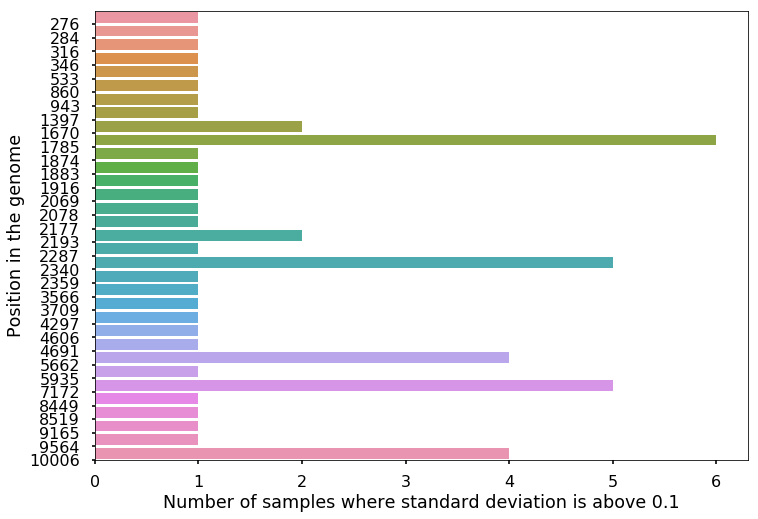

In [48]:

counts_sorted = sorted(counts.items())

labels, values = zip(*counts_sorted)

indexes = np.arange(len(labels))
width = 1


sns.set_palette("hls")
sns.set_context("poster")

a4_dims = (11.7, 8.27)

to_plot = pd.DataFrame ({'Position':indexes, 'standard_deviation':values}) 

fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(y="Position", x="standard_deviation", data=to_plot, orient="h")
ax.set(xlabel='Number of samples where standard deviation is above 0.1', ylabel='Position in the genome')
plt.yticks(indexes + width * 0.5, labels)
plt.show()

In [49]:
# Output positions of interest based on this analysis
varying_pos = [1670,1785,2193,2340,5662,7172,10006]

write_increasing_positions(varying_pos, all_tables, all_table_names, "varying_positions_all_samples.csv")


224


## Other selection method
We want to select all the positions in which the minor variant reaches >0.1 in at least two time points, in two different replicates or experiments.
To do so, we get the variant at time point 0, then we look at the following time points and see if one site has some minor variant >0.1 in 2 time points. We collect all the sites with this characteristic for this experiment.
We do this for all experiments, then we take all sites that appear at least twice.

In [50]:
def getInterestingVariants (tables):
    num_tables = len(tables)
    first = tables[0]
    last = tables[num_tables-1]
    major = ""
    minor = ""
    major_frequencies = array('d',[0.0]*num_tables)
    interestingVariants = list()
    for i in first["Position"]:
        minor_frequencies = array('d',[0.0]*num_tables)
        major = first["Major_variant"][i]
        minor = tables[-1]["Second_variant"][i]
        if minor == major:
            minor = tables[-1]["Major_variant"][i]
        counter = 0
        for j in range(num_tables):
            minor_frequencies[j] = get_variant_frequency(minor, tables[j], i)
            if minor_frequencies[j] > 0.1:
                counter += 1
        if counter >=2:
            interestingVariants.append(i)
    return interestingVariants
    


In [51]:
interesting_A = getInterestingVariants (tables_A)
interesting_D = getInterestingVariants (tables_D)
interesting_E = getInterestingVariants (tables_E)
interesting_TA = getInterestingVariants (tables_TA)
interesting_TD = getInterestingVariants (tables_TD)
interesting_TE = getInterestingVariants (tables_TE)

/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars


In [52]:
all_interesting = list()
all_interesting = all_interesting + interesting_A + interesting_D + interesting_E + interesting_TA + interesting_TD + interesting_TE
all_interesting

[316,
 1670,
 1785,
 2340,
 5662,
 5935,
 7172,
 8449,
 9165,
 926,
 1785,
 1916,
 2069,
 2193,
 2340,
 5662,
 6558,
 7172,
 10006,
 10806,
 533,
 1785,
 2340,
 4297,
 5662,
 7172,
 10006,
 1670,
 1785,
 1874,
 2340,
 3709,
 4606,
 5662,
 7172,
 8519,
 10006,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 943,
 1785,
 1883,
 4691,
 5662,
 9564,
 10006,
 0,
 1,
 2,
 3,
 1033,
 1397,
 1785,
 2177,
 2287,
 2340,
 5662,
 7172,
 10006,
 10805,
 10806]

In [53]:
 Counter(all_interesting)

Counter({0: 2,
         1: 2,
         2: 2,
         3: 2,
         4: 1,
         5: 1,
         6: 1,
         7: 1,
         316: 1,
         533: 1,
         926: 1,
         943: 1,
         1033: 1,
         1397: 1,
         1670: 2,
         1785: 6,
         1874: 1,
         1883: 1,
         1916: 1,
         2069: 1,
         2177: 1,
         2193: 1,
         2287: 1,
         2340: 5,
         3709: 1,
         4297: 1,
         4606: 1,
         4691: 1,
         5662: 6,
         5935: 1,
         6558: 1,
         7172: 5,
         8449: 1,
         8519: 1,
         9165: 1,
         9564: 1,
         10006: 5,
         10805: 1,
         10806: 2})

Therefore the positions of interest are: 0,1,2,3,1670,1785,2340,5662,7172,10006, 10806

In [54]:
for_output = [0,1,2,3,1670,1785,2340,5662,7172,10006, 10806]
write_increasing_positions(for_output, all_tables, all_table_names, "positions_morethan01_all_samples.csv")


352


## Analyses of all D samples vs all TD samples

In [55]:
all_interesting_D = list()
all_interesting_D = all_interesting_D + interesting_A + interesting_D + interesting_E 
all_interesting_D

[316,
 1670,
 1785,
 2340,
 5662,
 5935,
 7172,
 8449,
 9165,
 926,
 1785,
 1916,
 2069,
 2193,
 2340,
 5662,
 6558,
 7172,
 10006,
 10806,
 533,
 1785,
 2340,
 4297,
 5662,
 7172,
 10006]

In [56]:
 Counter(all_interesting_D)

Counter({316: 1,
         533: 1,
         926: 1,
         1670: 1,
         1785: 3,
         1916: 1,
         2069: 1,
         2193: 1,
         2340: 3,
         4297: 1,
         5662: 3,
         5935: 1,
         6558: 1,
         7172: 3,
         8449: 1,
         9165: 1,
         10006: 2,
         10806: 1})

In [57]:
all_interesting_TD = list()
all_interesting_TD = all_interesting_TD + interesting_TA + interesting_TD + interesting_TE
all_interesting_TD

[1670,
 1785,
 1874,
 2340,
 3709,
 4606,
 5662,
 7172,
 8519,
 10006,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 943,
 1785,
 1883,
 4691,
 5662,
 9564,
 10006,
 0,
 1,
 2,
 3,
 1033,
 1397,
 1785,
 2177,
 2287,
 2340,
 5662,
 7172,
 10006,
 10805,
 10806]

In [58]:
 Counter(all_interesting_TD)

Counter({0: 2,
         1: 2,
         2: 2,
         3: 2,
         4: 1,
         5: 1,
         6: 1,
         7: 1,
         943: 1,
         1033: 1,
         1397: 1,
         1670: 1,
         1785: 3,
         1874: 1,
         1883: 1,
         2177: 1,
         2287: 1,
         2340: 2,
         3709: 1,
         4606: 1,
         4691: 1,
         5662: 3,
         7172: 2,
         8519: 1,
         9564: 1,
         10006: 3,
         10805: 1,
         10806: 1})

### Analysis of positions 1670 and 2193

In [59]:
def test1670_2193 (tables):
    num_tables = len(tables)
    first = tables[0]
    last = tables[num_tables-1]
    major = ""
    minor = ""
    major_frequencies = array('d',[0.0]*num_tables)
    for i in [1670,2193]:
        minor_frequencies = array('d',[0.0]*num_tables)
        major = first["Major_variant"][i]
        minor = tables[-1]["Second_variant"][i]
        if minor == major:
            minor = tables[-1]["Major_variant"][i]
        counter = 0
        print(str(i)+" : ")
        for j in range(num_tables):
            minor_frequencies[j] = get_variant_frequency(minor, tables[j], i)
            print("\texp "+str(j) +", variant "+minor + " : "+str(minor_frequencies[j]))
            if minor_frequencies[j] > 0.1:
                counter += 1
        print("Counter of times > 0.1: "+ str(counter))
    return 
    


In [60]:
test1670_2193 (tables_A)

1670 : 
	exp 0, variant A : 0.0007159547990528399
	exp 1, variant A : 0.0012806886821730642
	exp 2, variant A : 0.0015129829785103697
	exp 3, variant A : 0.0015981568907384345
	exp 4, variant A : 0.01237672346640701
	exp 5, variant A : 0.22987622145031614
	exp 6, variant A : 0.9422872506633152
Counter of times > 0.1: 2
2193 : 
	exp 0, variant A : 0.004042173894754554
	exp 1, variant A : 0.004550078082888859
	exp 2, variant A : 0.0039348096481452
	exp 3, variant A : 0.004422164857789221
	exp 4, variant A : 0.0001862299764240174
	exp 5, variant A : 0.003578143245857551
	exp 6, variant A : 0.004363126555856206
Counter of times > 0.1: 0


In [61]:
test1670_2193 (tables_D)

1670 : 
	exp 0, variant A : 0.0011468723121116728
	exp 1, variant A : 0.0014240758848463582
	exp 2, variant A : 0.0013859568993177026
	exp 3, variant A : 0.0015223995082552678
	exp 4, variant A : 0.0022946868371490157
	exp 5, variant A : 0.004346169433025672
Counter of times > 0.1: 0
2193 : 
	exp 0, variant T : 0.00483789897841356
	exp 1, variant T : 0.008042975109968478
	exp 2, variant T : 0.0074605260911586365
	exp 3, variant T : 0.029990229898762603
	exp 4, variant T : 0.2875837468649808
	exp 5, variant T : 0.38051918168718885
Counter of times > 0.1: 2


In [62]:
test1670_2193 (tables_E)

1670 : 
	exp 0, variant A : 0.0009621655973182664
	exp 1, variant A : 0.00109570211429276
	exp 2, variant A : 0.0013113837481921293
	exp 3, variant A : 0.0014233398544335975
	exp 4, variant A : 0.007958058048474234
	exp 5, variant A : 0.014003046122399315
Counter of times > 0.1: 0
2193 : 
	exp 0, variant T : 0.002988701066275382
	exp 1, variant T : 0.00980698853793126
	exp 2, variant T : 0.009609920180157635
	exp 3, variant T : 0.00844740497471941
	exp 4, variant T : 0.06963156103781142
	exp 5, variant T : 0.6959940039544166
Counter of times > 0.1: 1


In [63]:
test1670_2193 (tables_TA)

1670 : 
	exp 0, variant A : 0.0011645268566709255
	exp 1, variant A : 0.0011143762888879052
	exp 2, variant A : 0.004166965598443926
	exp 3, variant A : 0.17227946842165234
	exp 4, variant A : 0.9785181967541058
Counter of times > 0.1: 2
2193 : 
	exp 0, variant A : 0.0042353315848385744
	exp 1, variant A : 0.004865809481843424
	exp 2, variant A : 0.000315273802688939
	exp 3, variant A : 0.0049459811974549035
	exp 4, variant A : 0.005020830767551042
Counter of times > 0.1: 0


In [64]:
test1670_2193 (tables_TD)

1670 : 
	exp 0, variant A : 0.00037840639902914064
	exp 1, variant A : 0.000455225889513008
	exp 2, variant A : 0.024518329955810127
	exp 3, variant A : 0.22071344497653944
Counter of times > 0.1: 1
2193 : 
	exp 0, variant T : 0.0011580225706368102
	exp 1, variant T : 0.0017845869773110226
	exp 2, variant T : 0.001986565972319375
	exp 3, variant T : 0.021437056675595374
Counter of times > 0.1: 0


In [65]:
test1670_2193 (tables_TE)

1670 : 
	exp 0, variant T : 0.0009673612267384917
	exp 1, variant T : 0.0010928920468342874
	exp 2, variant T : 0.0007582973709508883
	exp 3, variant T : 0.0018399845532608432
Counter of times > 0.1: 0
2193 : 
	exp 0, variant T : 0.1639320745771536
	exp 1, variant T : 0.09737595339624466
	exp 2, variant T : 0.017183524179587933
	exp 3, variant T : 0.002834303146679881
Counter of times > 0.1: 1


# Analysis of delta frequencies between time points

In [66]:
def get_delta(tables, j, i):
    sum_of_bases_j = tables[j]['As_quality_corrected'][i]+tables[j]['Cs_quality_corrected'][i]+tables[j]['Gs_quality_corrected'][i]+tables[j]['Ts_quality_corrected'][i]+tables[j]['Ns_quality_corrected'][i]
    sum_of_bases_j_1 = tables[j-1]['As_quality_corrected'][i]+tables[j-1]['Cs_quality_corrected'][i]+tables[j-1]['Gs_quality_corrected'][i]+tables[j-1]['Ts_quality_corrected'][i]+tables[j-1]['Ns_quality_corrected'][i]
 #   sum_of_squares = pow(tables[j]["As_quality_corrected"][i] / sum_of_bases_j - 
 #                        tables[j-1]["As_quality_corrected"][i] / sum_of_bases_j_1, 2) + pow(tables[j]["Cs_quality_corrected"][i] / sum_of_bases_j - 
 #                        tables[j-1]["Cs_quality_corrected"][i] / sum_of_bases_j_1, 2) + pow(tables[j]["Gs_quality_corrected"][i] / sum_of_bases_j - 
 #                        tables[j-1]["Gs_quality_corrected"][i] / sum_of_bases_j_1, 2) + pow(tables[j]["Ts_quality_corrected"][i] / sum_of_bases_j - 
 #                        tables[j-1]["Ts_quality_corrected"][i] / sum_of_bases_j_1, 2) 
    sum_of_abs = abs(tables[j]["As_quality_corrected"][i] / sum_of_bases_j - 
                         tables[j-1]["As_quality_corrected"][i] / sum_of_bases_j_1) + abs(tables[j]["Cs_quality_corrected"][i] / sum_of_bases_j - 
                         tables[j-1]["Cs_quality_corrected"][i] / sum_of_bases_j_1) + abs(tables[j]["Gs_quality_corrected"][i] / sum_of_bases_j - 
                         tables[j-1]["Gs_quality_corrected"][i] / sum_of_bases_j_1) + abs(tables[j]["Ts_quality_corrected"][i] / sum_of_bases_j - 
                         tables[j-1]["Ts_quality_corrected"][i] / sum_of_bases_j_1) 
    return sum_of_abs
        

def getDeltas (tables):
    num_tables = len(tables)
    first = tables[0]
    last = tables[num_tables-1]
    major = ""
    minor = ""
    deltas = list()
    for i in range(num_tables - 1):
        deltas.append( array('d',[0.0]*len(first["Position"])) )
    interestingVariants = list()
    for i in first["Position"]:
      # minor_frequencies = array('d',[0.0]*num_tables)
        #major = first["Major_variant"][i]
        #minor = tables[-1]["Second_variant"][i]
        #if minor == major:
        #    minor = tables[-1]["Major_variant"][i]
        for j in range(num_tables-1):
            deltas[j][i] = get_delta(tables, j, i)
            #deltas[j][i] = abs ( get_variant_frequency(minor, tables[j], i) - get_variant_frequency(minor, tables[j-1], i) )
    names = list()
    d = list()
    ld = list()
    for j in range(num_tables-1):
        for i in first["Position"]:
            names.append(str(j))
            d.append(deltas[j][i])
            ld.append(math.log(deltas[j][i]+1e-9))
    d2 = {'names':names, 'deltas':d}
    ld2 = {'names':names, 'deltas':ld}
    df = pd.DataFrame(d2)
    ldf = pd.DataFrame(ld2)
    return df, ldf



def plotDeltas(d):
    sns.set_style("whitegrid")
    ax = sns.violinplot(d["names"], y=d["deltas"], inner=None)
    #ax = sns.swarmplot(d["numCons"], y=d["correlation_bl"], color="white", edgecolor="gray")
    ax.set(xlabel='Between-sample deltas', ylabel='Delta values')

def plotLogDeltas(d):
    sns.set_style("whitegrid")
    ax = sns.boxplot(d["names"], y=d["deltas"])
    #ax = sns.swarmplot(d["numCons"], y=d["correlation_bl"], color="white", edgecolor="gray")
    ax.set(xlabel='Between-sample deltas', ylabel='Delta values')
    ax.set_yscale('log')

## Tables A

In [67]:
d_A, ld_A = getDeltas (tables_A)

/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


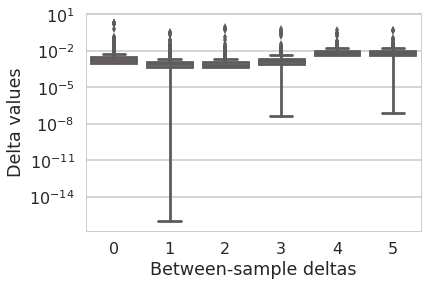

In [68]:
%matplotlib inline
plotLogDeltas(d_A)

## Tables D

In [69]:
d_D, ld_D = getDeltas (tables_D)

/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


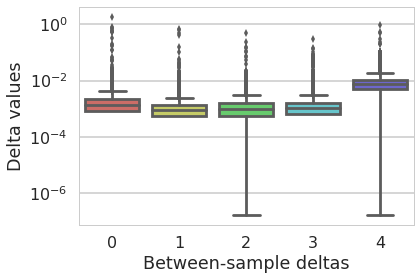

In [70]:
%matplotlib inline
plotLogDeltas(d_D)

## Tables E

In [71]:
d_E, ld_E = getDeltas (tables_E)

/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


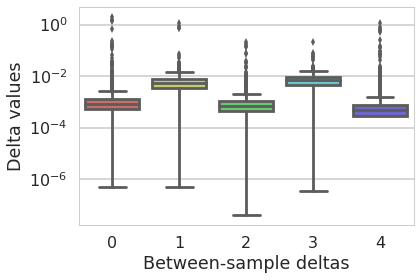

In [72]:
%matplotlib inline
plotLogDeltas(d_E)

## Tables TA

In [73]:
d_TA, ld_TA = getDeltas (tables_TA)

/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


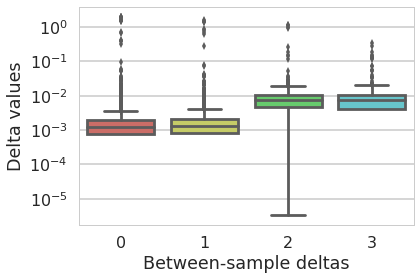

In [74]:
%matplotlib inline
plotLogDeltas(d_TA)

## Tables TD

In [75]:
d_TD, ld_TD = getDeltas (tables_TD)

/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


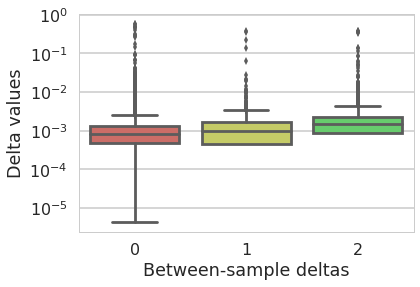

In [76]:
%matplotlib inline
plotLogDeltas(d_TD)

## Tables TE

In [77]:
d_TE, ld_TE = getDeltas (tables_TE)

/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


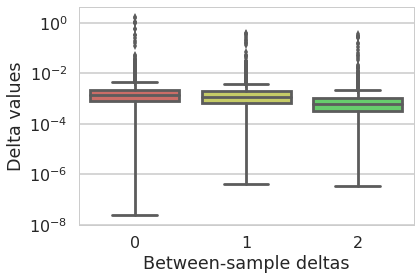

In [78]:
%matplotlib inline
plotLogDeltas(d_TE)

# Choosing a threshold on deltas

In [79]:
deltas = list()
deltas = deltas + d_TE['deltas'].tolist() + d_TD['deltas'].tolist() + d_TA['deltas'].tolist() + d_E['deltas'].tolist() + d_D['deltas'].tolist() + d_A['deltas'].tolist()
print(len(deltas))

280982


In [80]:
log_deltas = list()
print(type( ld_TE['deltas']))
log_deltas = log_deltas + ld_TE['deltas'].tolist() + ld_TD['deltas'].tolist() + ld_TA['deltas'].tolist() + ld_E['deltas'].tolist() + ld_D['deltas'].tolist() + ld_A['deltas'].tolist()
print(len(log_deltas))

<class 'pandas.core.series.Series'>
280982


## Value such that only 5% of the deltas are greater

In [81]:
a = np.array(deltas)
p = np.nanpercentile(a, 95) # return 95th percentile.
print(p)
a = np.array(log_deltas)
logp = np.nanpercentile(a, 95) # return 95th percentile.
print(logp)


0.0107523257931
-4.53263310197


/home/boussau/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/home/boussau/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


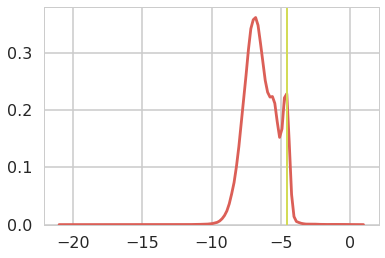

In [82]:
sns.kdeplot(log_deltas)
plt.plot([logp, logp], [0, 1], linewidth=2)

### Let's compare to -5 as a threshold:

/home/boussau/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/home/boussau/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


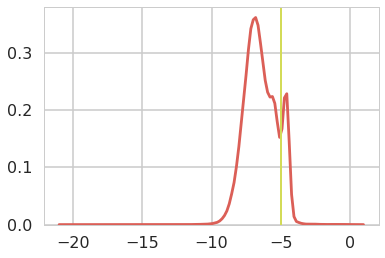

In [83]:
sns.kdeplot(log_deltas)
plt.plot([-5, -5], [0, 1], linewidth=2)

## Let's use -5 as a threshold to analyse deltas through time

In [84]:

def plotDeltasThreshold(d, threshold):
    sns.set_style("whitegrid")
    # Create variable with TRUE if delta is greater than threshold
    good = d['deltas'] > threshold
    df = d[good]
    ax = sns.violinplot(df["names"], y=df["deltas"], inner=None)
    #ax = sns.swarmplot(d["numCons"], y=d["correlation_bl"], color="white", edgecolor="gray")
    ax.set(xlabel='Between-sample deltas', ylabel='Delta values')

def plotLogDeltasThreshold(d, threshold):
    sns.set_style("whitegrid")
    # Create variable with TRUE if delta is greater than threshold
    good = d['deltas'] > math.exp(threshold)
    df = d[good]
    ax = sns.boxplot(df["names"], y=df["deltas"])
    #ax = sns.swarmplot(d["numCons"], y=d["correlation_bl"], color="white", edgecolor="gray")
    ax.set(xlabel='Between-sample deltas', ylabel='Delta values')
    ax.set_yscale('log')

## Tables A

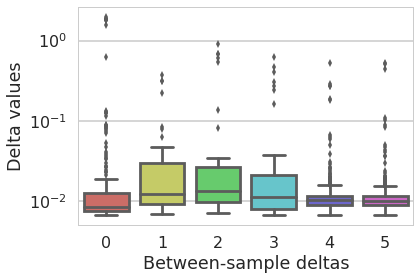

In [85]:
plotLogDeltasThreshold(d_A, -5)

## Tables D

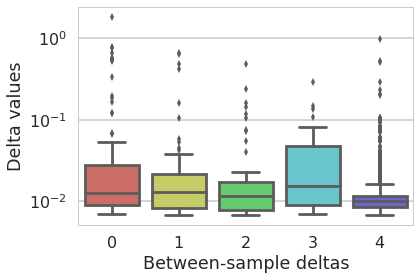

In [86]:
plotLogDeltasThreshold(d_D, -5)

## Tables E

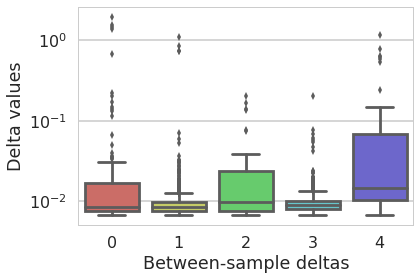

In [87]:
plotLogDeltasThreshold(d_E, -5)

## Tables TA

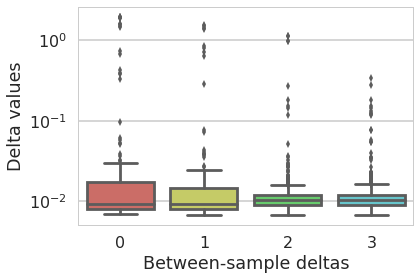

In [88]:
plotLogDeltasThreshold(d_TA, -5)

## Tables TD

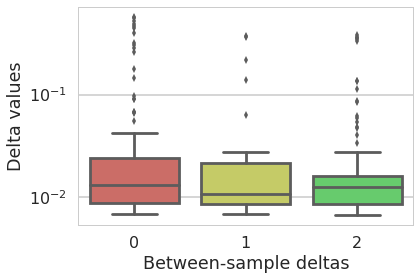

In [89]:
plotLogDeltasThreshold(d_TD, -5)

## Tables TE

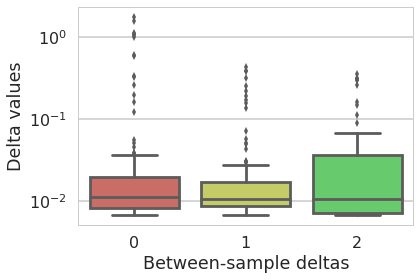

In [90]:
plotLogDeltasThreshold(d_TE, -5)

# Density plots of the diversity in different samples

## A

/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # 

(0, 1.2)

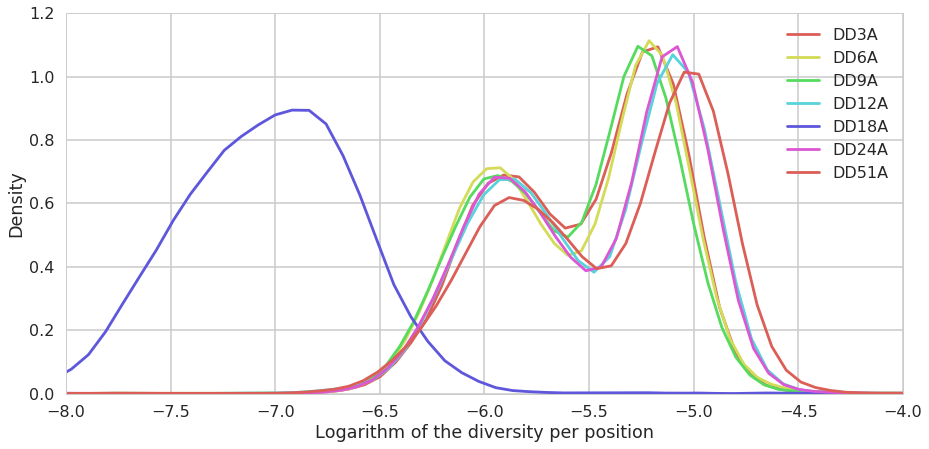

In [107]:
f, ax = plt.subplots(figsize=(15, 7))
lm=sns.kdeplot(np.log(tables_A[0]["1_major_variant_frequency"]), label="DD3A")
lm.set_ylabel('Density')
lm.set_xlabel('Logarithm of the diversity per position')

lm=sns.kdeplot(np.log(tables_A[1]["1_major_variant_frequency"]), label="DD6A")
lm=sns.kdeplot(np.log(tables_A[2]["1_major_variant_frequency"]), label="DD9A")
lm=sns.kdeplot(np.log(tables_A[3]["1_major_variant_frequency"]), label="DD12A")
lm=sns.kdeplot(np.log(tables_A[4]["1_major_variant_frequency"]), label="DD18A")
lm=sns.kdeplot(np.log(tables_A[5]["1_major_variant_frequency"]), label="DD24A")
lm=sns.kdeplot(np.log(tables_A[6]["1_major_variant_frequency"]), label="DD51A")

axes = lm.axes
axes.set_xlim(-8,-4)
axes.set_ylim(0,1.2)

# D

/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


(0, 1.2)

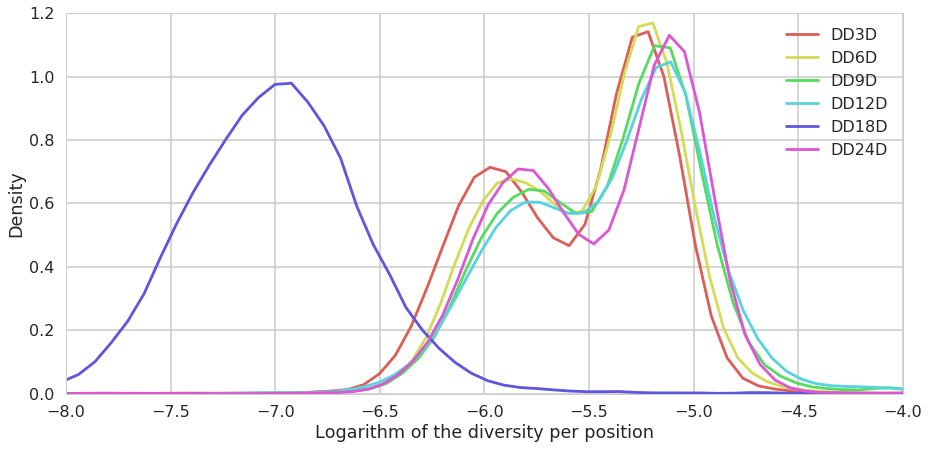

In [106]:
f, ax = plt.subplots(figsize=(15, 7))
lm=sns.kdeplot(np.log(tables_D[0]["1_major_variant_frequency"]), label="DD3D")
lm.set_ylabel('Density')
lm.set_xlabel('Logarithm of the diversity per position')

lm=sns.kdeplot(np.log(tables_D[1]["1_major_variant_frequency"]), label="DD6D")
lm=sns.kdeplot(np.log(tables_D[2]["1_major_variant_frequency"]), label="DD9D")
lm=sns.kdeplot(np.log(tables_D[3]["1_major_variant_frequency"]), label="DD12D")
lm=sns.kdeplot(np.log(tables_D[4]["1_major_variant_frequency"]), label="DD18D")
lm=sns.kdeplot(np.log(tables_D[5]["1_major_variant_frequency"]), label="DD24D")

axes = lm.axes
axes.set_xlim(-8,-4)
axes.set_ylim(0,1.2)


# E

/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


(0, 1.2)

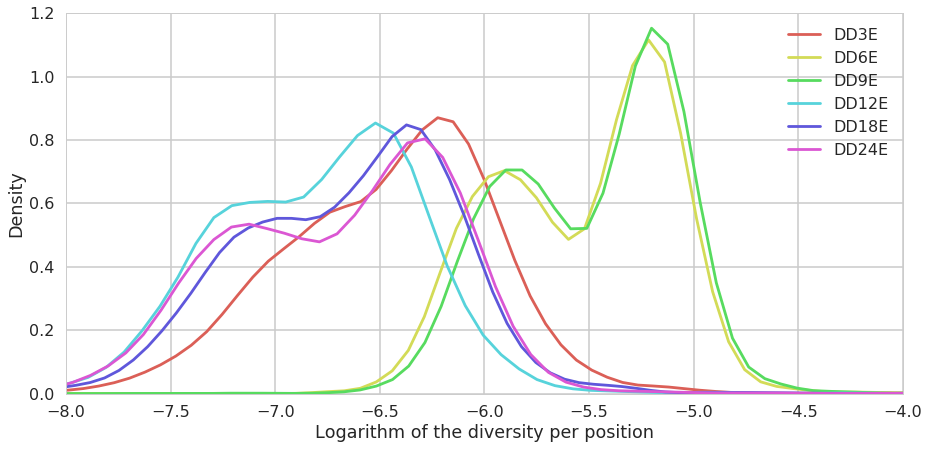

In [105]:
f, ax = plt.subplots(figsize=(15, 7))
lm=sns.kdeplot(np.log(tables_E[0]["1_major_variant_frequency"]), label="DD3E")
lm.set_ylabel('Density')
lm.set_xlabel('Logarithm of the diversity per position')

lm=sns.kdeplot(np.log(tables_E[1]["1_major_variant_frequency"]), label="DD6E")
lm=sns.kdeplot(np.log(tables_E[2]["1_major_variant_frequency"]), label="DD9E")
lm=sns.kdeplot(np.log(tables_E[3]["1_major_variant_frequency"]), label="DD12E")
lm=sns.kdeplot(np.log(tables_E[4]["1_major_variant_frequency"]), label="DD18E")
lm=sns.kdeplot(np.log(tables_E[5]["1_major_variant_frequency"]), label="DD24E")

axes = lm.axes
axes.set_xlim(-8,-4)
axes.set_ylim(0,1.2)


# TA

/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


(0, 1.2)

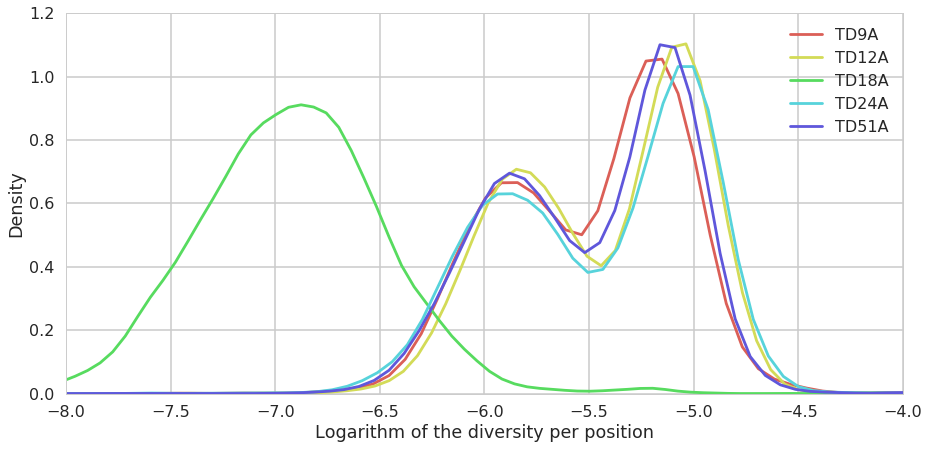

In [103]:
f, ax = plt.subplots(figsize=(15, 7))
lm=sns.kdeplot(np.log(tables_TA[0]["1_major_variant_frequency"]), label="TD9A")
lm.set_ylabel('Density')
lm.set_xlabel('Logarithm of the diversity per position')

lm=sns.kdeplot(np.log(tables_TA[1]["1_major_variant_frequency"]), label="TD12A")
lm=sns.kdeplot(np.log(tables_TA[2]["1_major_variant_frequency"]), label="TD18A")
lm=sns.kdeplot(np.log(tables_TA[3]["1_major_variant_frequency"]), label="TD24A")
lm=sns.kdeplot(np.log(tables_TA[4]["1_major_variant_frequency"]), label="TD51A")

axes = lm.axes
axes.set_xlim(-8,-4)
axes.set_ylim(0,1.2)


# TD

/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


(0, 1.2)

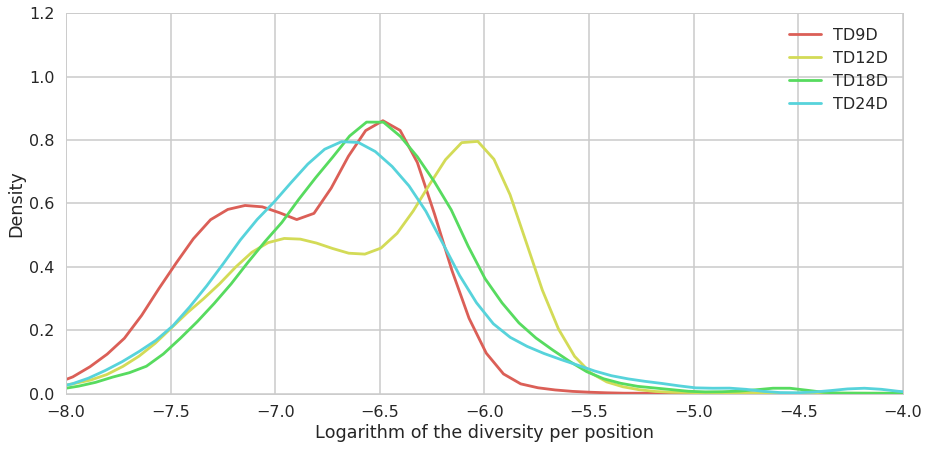

In [109]:
f, ax = plt.subplots(figsize=(15, 7))
lm=sns.kdeplot(np.log(tables_TD[0]["1_major_variant_frequency"]), label="TD9D")
lm.set_ylabel('Density')
lm.set_xlabel('Logarithm of the diversity per position')

lm=sns.kdeplot(np.log(tables_TD[1]["1_major_variant_frequency"]), label="TD12D")
lm=sns.kdeplot(np.log(tables_TD[2]["1_major_variant_frequency"]), label="TD18D")
lm=sns.kdeplot(np.log(tables_TD[3]["1_major_variant_frequency"]), label="TD24D")

axes = lm.axes
axes.set_xlim(-8,-4)
axes.set_ylim(0,1.2)


/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


(0, 1.2)

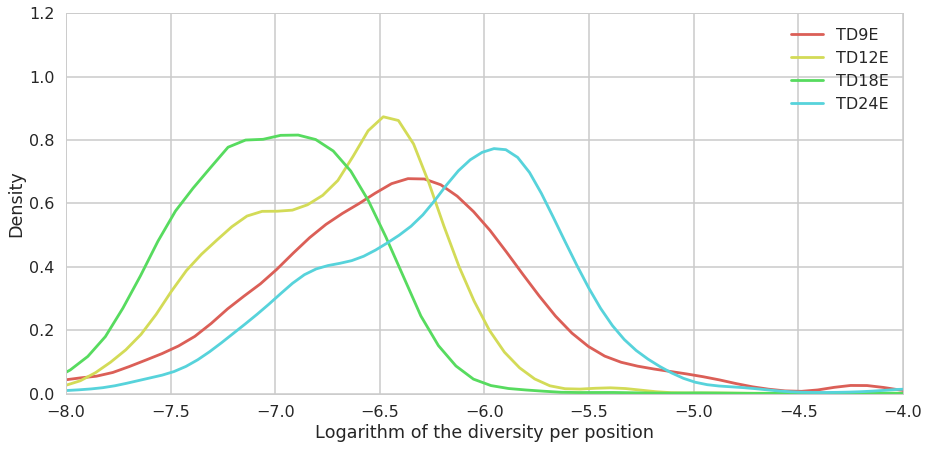

In [108]:
f, ax = plt.subplots(figsize=(15, 7))
lm=sns.kdeplot(np.log(tables_TE[0]["1_major_variant_frequency"]), label="TD9E")
lm.set_ylabel('Density')
lm.set_xlabel('Logarithm of the diversity per position')

lm=sns.kdeplot(np.log(tables_TE[1]["1_major_variant_frequency"]), label="TD12E")
lm=sns.kdeplot(np.log(tables_TE[2]["1_major_variant_frequency"]), label="TD18E")
lm=sns.kdeplot(np.log(tables_TE[3]["1_major_variant_frequency"]), label="TD24E")

axes = lm.axes
axes.set_xlim(-8,-4)
axes.set_ylim(0,1.2)
